## Imports

In [ ]:
!pip install Unidecode
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np
from numpy import hstack
from numpy import vstack
from numpy import asarray
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
import pickle
import umap
import re
import string
from string import punctuation
#from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,\
                         ShuffleSplit,StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from mlxtend.classifier import EnsembleVoteClassifier
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('rslp')

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path_modelos = '/content/drive/My Drive/Residencia/Tcc/Modelos_Treinamento/'
path_modelos2 = '/content/drive/My Drive/Residencia/Tcc/Modelos_Treinados/'
path_tcc = '/content/drive/My Drive/Residencia/Tcc/'

Mounted at /content/drive


In [4]:
#https://fasttext.cc/docs/en/support.html
'''
!pip install fasttext
import fasttext
import fasttext.util
fasttext.util.download_model('pt')
ft = fasttext.load_model('cc.pt.300.bin')'''

"\n!pip install fasttext\nimport fasttext\nimport fasttext.util\nfasttext.util.download_model('pt')\nft = fasttext.load_model('cc.pt.300.bin')"

In [5]:
#http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc
'''!pip install gensim==2.0.0
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(‘model.txt’)'''

'!pip install gensim==2.0.0\nfrom gensim.models import KeyedVectors\nmodel = KeyedVectors.load_word2vec_format(‘model.txt’)'

## Funções e constantes

In [6]:
lista_lt = ['li','lr','lit','litro', 'litros', 'ltr', 'l','lt', 'lts','ltrs']
lista_kg = ['kg','kgs','quilo','quilos','kilos','kilos','kgas','kga','kg1', 'kg3', 'kg2']
lista_und = ['unidade','unidades','und','un','un0001','unid','un1','uni','un.','unid.','unidad','ud'] #,'lata','lat', 'embal','garraf','garrafa','rl'
lista_pct = ['pcts','pct','pc','pc1','pact','pacote','pa','pcs']
lista_cx = ['cx','caixa','cx20','cx12','cx48','cxs','cxa','cx24']
lista_frd = ['fdo','fardo','frd','fd','fd12','fr','far','fd27','fdo']
lista_m = ['metros','m','mts']
lista_g = ['grama','gramas','g','gr','grs']
lista_sc = ['saco','sc']
lista_geral = ['lt','kg','und','pct','cx','frd', 'sc', 'g','m','mg','cm','mm','ml']
unidades = set(lista_lt+lista_kg+lista_und+lista_pct+lista_cx+lista_frd+lista_m+lista_g+lista_sc)
pt_stopwords = set(nltk.corpus.stopwords.words("portuguese"))
punct = set(list(punctuation))
pt_stopwords.update(punct)
stopwords = set(['gtin','ok','tipo', 'data','fabricacao','fabricante','fabricado','lote','lotes','marca','embalagem','embalagens','embalados','frasco','fr','fc','sache','sacher','sachet','und','emb','marca','pct',\
                 'pc','sc','fd','pacote','pacotes','refil','rf','cx','pote','qtd','todo','cs','tp','endereco','sa','dr','mr','am','az','1a','1o','qualidade','vermelha','vermelho','preta','preto','branco',\
                 'amarelo','amarela','verde','azul','laranja','rosa','cor','cores','colorido','sabor','sabores','variadas','variada','variados','sortido','sortida','estrela','in','natura',\
                 'lavanda','campo','floral','flor','flores','aerosol','spray','sadia','ltda','becker','pbl','liquido','liquida','liq','marata','brw','totalplast','zap','clean','material',\
                 'office','oficio','capacidade','cap','premium','ultra','original','hospitalar','puro','sabor','galp','re','sadio','san','ville','vale','etilico','sodio','belo','grao','instantaneo',\
                 'masterprint','clara','air','fino','santa','cruz','kimimo','hidracor','hidro','harpic','guarani','ype','neutro','rei','ouro','plastica','plastico','plast','pet','chanfrada',\
                 'chanfradas','uht','comum','novo','real','base','tamanho','flip','top','galao','tradicional','trad','classico','apresentacao','uso','domestico','bom','todo','algas','marinhas',\
                 'validade','val','entrega','meses','inpm','hidratado','brasil','br','bb','industria','seguinte','composicao','contendo','norma','abnt','simples'])

In [7]:
'''teste = df_treino[df_treino['Produto']=='detergente concentrado gel 500ml cx 24 und']
teste['xprod']=teste['Produto']
teste = limpa_descricoes(teste,'xprod')
teste'''

"teste = df_treino[df_treino['Produto']=='detergente concentrado gel 500ml cx 24 und']\nteste['xprod']=teste['Produto']\nteste = limpa_descricoes(teste,'xprod')\nteste"

In [8]:
def limpa_descricoes(df_produto, column):
  
  def remove_numeros_inicio(descr):
    while ( (len(descr) > 1) and (descr.split()[0].isdigit()) ):
      descr = ' '.join( descr.split()[1:] )
    return descr
  
  def remove_numeros_soltos(descr):
    while any(str.isdigit(word) for word in descr.split()) and (bool(re.search(r'\d[a-z]', descr)) and 'alcool' not in descr):
      descr = re.sub(r'(((\d+(\.|\,)\d+)|\d+)$)|( \d+ | (\d+(\.|\,)\d+) )',r' ',descr)    
    return descr

  # limpa sentencas retirando stopwords e deixa minusculo.
  df_produto.loc[:, column] = [ ' '.join([word.lower() for word in descr.split() if word.lower() not in pt_stopwords]) for descr in df_produto[column].astype(str)]
  #35-029.021.035- em inicios de descr
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'\d{2}-\d{3}\.\d{3}\.\d{3}-',r'',x))
  # remove lote
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(lote:|lote: )((\d+\.\w+\-\d+)|(\w+\d+|\d+\,\d+\-\d+))',r'',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(lotes) ([a-z]\d+ \d+ \d+)',r'',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(lotes) (\d+ \d+ \d+)',r'',x))
  # remove padrão de endereço  u01galp4seb, u01galp1se"e01", u01galp1lote2, u01galp1sea01
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'\bu01[a-z0-9]*',r'',x))
  # remove validade val:07/2022
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(validade|val):\d{2}\/\d{4}',r'',x))
  # insere espaco apos / . e -, pra no final nao ficar palavras assim: csolucao, ptexto defliq (originais eram c/solucao, p-texto, def.liqu) 
  df_produto.loc[:, column] = df_produto[column].apply(lambda descr: re.sub(r'/|-|:',r' ',descr))
  # retira . entre palavras tipo det.liqu 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ' '.join( [re.sub(r'\.',r' ', word) if '.' in word and not any(char.isdigit() for char in word) else word for word in x.split()] ) )
  # retira pontuacao (com exceção de virgula e ponto dos numeros):
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ''.join(re.findall('\d+\.\d+|\d+\,\d+|\w|\s', x)))
  # insere espaco apos numero e letra (separa unidades de medida:) ex.: 500ml vs 100ml vs 500mg
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)([A-Za-z])',r'\1 \2',x))
  # insere espaco apos letra e numero ex.:c100 pc50
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'([A-Za-z]{1})(\d+)',r'\1 \2',x))
  # retira espacos duplicados
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' +',r' ', x))
  # retira espaco no inicio da frase
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x.strip())
  # retira acentos:
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: unidecode.unidecode(x))
  # remove numeros mt longos
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'\d{5,}',r'',x))
  # remove zeros a esquerda de numeros (02 litros, 05, etc.) caso não tenha , e . 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ' '.join( [word2.lstrip('0') for word2 in x.split()] if not any(bool(re.search(r',|\.', word)) for word in x.split()) else [word2 for word2 in x.split()]) )
  # nulo descr vazia
  df_produto.loc[:, column] = df_produto[column].replace('^\s*$|^$', np.NaN, regex=True)
  df_produto = df_produto.dropna(subset=[column])
  # muda l e lts e litros por lt
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' lts | ltrs | litros | litro | lito | li | l ', r' lt ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' kgs | kilos | kilo | quilos | quilo | kgas | kga | k ', r' kg ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' grama | gramas | grs | gr ', r' g ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d) (folhas|folha|flhas|fls|f) ',r'\1fl ',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' rolos | rolo | rls | rol | ro ', r' rl ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' metros | metro | mtrs | mts | mt ', r' m ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' unidades | unidade | unids | un | unid | uni | unds ', r' und ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' caixas | caixa | cxa ', r' cx ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' fardos | fardo | fard | frd | frd | fdo ', r' fd ', x))
  # muda l e lts por lt se for no final de frase
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['l', 'li','lts','lito','litro','litros','ltrs'] else ' '.join((' '.join(x.split()[:-1]), 'lt')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['kgs', 'kga', 'kilos','kilo','quilos', 'quilo','k'] else ' '.join((' '.join(x.split()[:-1]), 'kg')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['gramas', 'grama','grs','gr'] else ' '.join((' '.join(x.split()[:-1]), 'g')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['folhas', 'folha','flhas','f','fls'] else ' '.join((' '.join(x.split()[:-1]), 'fl')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['rolos', 'rolo','rls','rol','ro'] else ' '.join((' '.join(x.split()[:-1]), 'rl')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['metro', 'metros','mtrs','mts','mt'] else ' '.join((' '.join(x.split()[:-1]), 'm')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['unids', 'unid','un','unidade','unidades','uni','unds'] else ' '.join((' '.join(x.split()[:-1]), 'und')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['caixas', 'caixa','cxa'] else ' '.join((' '.join(x.split()[:-1]), 'cx')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['fardos','fardo', 'fard','frd','fdo'] else ' '.join((' '.join(x.split()[:-1]), 'fd')))
  # substitui 1000ml por 1l se vier só 1000 some
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d)(000 ml|.000 ml)',r'\1lt',x))
  # junta numeros antes de apagar fardo com \d (ex:papel higienico fardo c/ 16x4 novo = papelhigien 4
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+) (x|\*) (\d+)',r'\1\2\3',x)) # 10 x 100g: 10x100g (para remover 10 dps)
  # remove espaço com unidades
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+) (lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)(\s|$)',r'\1\2 ',x))
  # remove quantidade tipo cx c 12 und
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(cx|fd)(\sc\s|\scom\s|)((\d+(\.|\,)\d+)\s|\d+\s)(und|resmas|resma)',r' ',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(cx|fd)(\sc\s|\scom\s)((\d+(\.|\,)\d+)|\d+) ',r' ',x))
  # se primeira palavra for numero apaga (checa varias vezes)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: remove_numeros_inicio(x))
  # apaga 40.00 kg
  df_produto.loc[:,column] = df_produto[column].apply(lambda x: re.sub(r'(\d+(\.|\,)\d+)(kg|und)',r'',x))
  # remove espaços específicos
  #df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d) (m) (\d)',r'\1\2\3',x)) # 10m3 0,7m3
  #df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'0,7m3',r'7m3',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' bs ',r' b s ',x)) # conserta diesel b s 500
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' (s) ((500)|(10))',r' \1\2',x)) # conserta diesel b s500
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' a 4',r' a4',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'saco (plastico|plast|p|plastico p|plast p) ',r'saco ',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(sabao|sab|det|deterg|detergente|tinta|achocolatado|achoc|farinha|colorau|coloral|colorifico|extra|ponta|multi|dupla|marca|sao|coca|motor|madeira|saco|sacos|agua|total|pinho|star|lustra|leite|bom|copo|papel|super|anti|pre|lapis|lava|flocos) (barra|po|forte|trigo|agulha|uso|face|texto|braz|cola|diesel|macica|lixo|sanitaria|sanit|plast|sol|lux|mov|moveis|ar|desc|higienico|hig|toalha|cal|septico|cozido|cor|louca|loucas|milho)(\s|$)',r'\1\2 ',x)) 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(erva|3|longa|100|pronto|zero|aspecto|uso|vitaminas) (doce|bem|coracoes|vida|algodao|uso|lactose|fisico|geral|minerais)',r'',x))
  #específicos classes: papel hig 16x4, feijão fava branca papel peso 60
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'16x4',r'64rl',x) if 'hig' in x else x)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'branca',r'',x) if 'feijao' in x else x) 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(peso) (\d+)',r'\1\2',x) if 'papel' in x else x)
  pt_stopwords.update(stopwords)
  #19x19x09 e 19x19x09cm
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(x|\*)(\d+)(x|\*)(\d+)(\s|$)',r'', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(x|\*)(\d+)(x|\*)(\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)',r'', x))
  #remove qtd comprada 200x de 200x300ml se n for papel hig
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(x|\*)(\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)',r'\3\4', x) if 'hig' not in x else re.sub(r'(\d+)(x|\*)(\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)',r'\1rl', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(x|\*)(\d+)(\s|$)',r'', x)) # if any(bool(re.search(r'\d(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)', word)) for word in x.split()) else re.sub(r'(\d+)(x|\*)(\d+)',r'\3', x))
  #c 8 (trata papel hig) ou 4un
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' (c|com|cx|qtd) (\d+|(\d+(\.|\,)\d+))(\s|$)',r' ', x) if 'hig|toalha|rl' not in x else re.sub(r' (c|com|cx|qtd) (\d+|(\d+(\.|\,)\d+))(\s|$)',r' \2rl ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' (\d+|(\d+(\.|\,)\d+))(und)(\s|$)',r' \1rl ', x) if 'hig' in x else x)
  # apaga dimensoes 30mx10mm
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+|(\d+(\.|\,)\d+)) (lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)(x|\*) (\d+|(\d+(\.|\,)\d+))(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furo|furo)',r'',x))
  #df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+|(\d+(\.|\,)\d+))(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)(x|\*)(\d+|(\d+(\.|\,)\d+))(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)',r'',x))
  #100mm x 70mm x 20mm 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo) (x|\*) (\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und) (x|\*) (\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)|(\d+)(x|\*)(\d+)$',r'', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+) (lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)(x|\*) ((\d+) (lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)(x|\*)|)(\s|)(\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)',r'',x)) 
  #apaga mais dimensões
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(mm|m |m$|cm)',r'',x)) 
  # apaga numeros soltos em caso de haver número com unidade 50ml e não apaga caso não haja 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: remove_numeros_soltos(x))
  #apaga und se não for a unidade de medida da descr
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(und)',r'',x) if bool(re.search(r'\d(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|furo|furos)(\s|$)', x)) else x )
  # substitui palavras repetidas kg kg por kg
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'\b(\w+)\s+\1\b',r'\1',x))
  # retira espacos duplicados e strip (2)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' +',r' ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x.strip())
  # limpa palavras novamente
  df_produto.loc[:, column] = [ ' '.join([word for word in descr.split() if word.lower() not in pt_stopwords]) for descr in df_produto[column].astype(str)]
  # apaga caracteres pequenos se n estiver nas condições
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1 or word.isdigit() or word in lista_geral]))
  # aplica nulo a descr pequena
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x if len(x.split()) > 1 else np.NaN)
  df_produto = df_produto.dropna(subset=[column])
  # limita descr a 10
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ' '.join(x.split()[:8]))

  return df_produto

In [9]:
def grava(obj, filename):
    with open(filename, 'wb') as pkl_file:
      pickle.dump(obj, pkl_file)

def abre(filename):
    with open(filename, 'rb') as pkl_file:
      obj = pickle.load(pkl_file)
      return obj

def pre_processing_pln(df, column):
    
    lemmatizer=WordNetLemmatizer()
    stemmer = nltk.stem.RSLPStemmer()

    df[column] = df[column].apply(lambda x: ' '.join([ lemmatizer.lemmatize(item) for item in x.split() ] ))
    df[column] = df[column].apply(lambda x: ' '.join([ stemmer.stem(item) for item in x.split()] ))

    return df

def calc_preco(df, grupos, descricoes):

  groupos_id = []
  group_names = []
  media = []
  mediana = []
  media_saneada = []
  precos_max = []
  precos_min = []
    
  for i, grupo in enumerate(grupos):
    df_grupo = df[df['classe'] == grupo]

    #S = E – M sobrepreço estimado - referencial mercado
    media.append(round(df_grupo['vuncom'].mean(),3))
    mediana.append(round(df_grupo['vuncom'].median(),3))
    nova_media, preco_max, preco_min = calc_media_saneada(df_grupo)
    
    media_saneada.append(nova_media)
    precos_max.append(preco_max)
    precos_min.append(preco_min)

    descricao = descricoes[i]
    group_names.append(descricao)
    
    groupos_id.append(i+1)

  df_precos = pd.DataFrame(zip(groupos_id, group_names, media, mediana, precos_max, precos_min, media_saneada),\
                            columns=["id","Classe", "Media", "Mediana", "Max", "Min", "Media Saneada"])

  df_precos = df_precos.round(2)
  df_precos['Media'] = df_precos['Media'].astype(str).str.replace('.',",")  
  df_precos['Mediana'] = df_precos['Mediana'].astype(str).str.replace('.',",")  
  df_precos['Max'] = df_precos['Max'].astype(str).str.replace('.',",")  
  df_precos['Min'] = df_precos['Min'].astype(str).str.replace('.',",")  
  df_precos['Media Saneada'] = df_precos['Media Saneada'].astype(str).str.replace('.',",")

  df_precos.set_index('id', inplace=True)
  #load precos filename
  df_precos.to_csv('precos_produtos.csv', encoding='utf-8-sig')
	

def calc_media_saneada(df):
  '''
  '''
  preco = df['vuncom']
  preco_max = max(preco)
  preco_min = min(preco)
  preco_mean = preco.mean()
  LS = preco_mean + preco.std()
  LI = preco_mean - preco.std()		
  CV = abs(preco.std() / preco_mean)

  if CV > 0.25:
    precos = preco[preco.between(LI, LS)]
    return (precos.mean(), preco_max, preco_min)
  else:
    return (preco_mean, preco_max, preco_min)


def reindex_grupos(df):
  classes = df['classe'].unique().tolist()
  classes.sort()
  reindex={}
  for i, classe in enumerate(classes):
    reindex[classe] = i+1
  df['classe'] = df['classe'].map(reindex)
  
  return df

## Obtem dados

In [ ]:
df = pd.read_csv('produtos.csv')
df_produtos = pd.read_csv('produtos_classes.csv')
df_produtos.rename(columns={'classificacao': 'definicao', 'xprod':'Produto'}, inplace=True)

df['Produto'] = df['xprod']
df = limpa_descricoes(df, 'xprod')

grava(df, path_tcc+'produtos.pkl')
grava(df_produtos, path_tcc+'produtos_classes.pkl')

In [ ]:
df = abre(path_tcc+'produtos.pkl')
df_produtos = abre(path_tcc+'produtos_classes.pkl')
print(f'Produtos classificados: {len(df_produtos)}')
print(f'Produtos em sua distribuição original: {len(df)}')

Produtos classificados: 22641
Produtos em sua distribuição original: 695684


In [ ]:
#aplica classificações de unique à distribuição original
df['definicao'] = df['Produto'].apply(lambda x: df_produtos.iloc[df_produtos.index[df_produtos['Produto'] == x].tolist()[0]]['definicao'] if x in df_produtos.Produto.values else np.NaN)
df_test = df[df['definicao'].isna()]
df_test = df_test.drop_duplicates(subset='xprod')
df_test = df_test.loc[df_test['xprod'].str.len() > 1]
df = df[~df['definicao'].isna()]
df_test['definicao'] = 1000
print(f"'Outros' fora de treinamento e validação: {len(df_test)}")

'Outros' fora de treinamento e validação: 172437


In [ ]:
#Filtrar por qtd de amostras total
class_size = 350
counts = df['definicao'].value_counts()
df = df[df['definicao'].isin(counts[counts > class_size].index)]
print(len(df['xprod'].unique().tolist()))
print(f"{len(df['definicao'].unique().tolist())} classes de produtos")

8848
102 classes de produtos


In [ ]:
#Filtrar por qtd de amostras unicas
'''class_size = 50
df2 = df.drop_duplicates(subset='xprod')
counts = df2['definicao'].value_counts()
df2 = df2[df2['definicao'].isin(counts[counts > class_size].index)]
print(f"{len(df2['definicao'].unique().tolist())} classes de produtos")'''

'class_size = 50\ndf2 = df.drop_duplicates(subset=\'xprod\')\ncounts = df2[\'definicao\'].value_counts()\ndf2 = df2[df2[\'definicao\'].isin(counts[counts > class_size].index)]\nprint(f"{len(df2[\'definicao\'].unique().tolist())} classes de produtos")'

In [ ]:
le = LabelEncoder()
df['definicao_texto'] = df['definicao']
df.definicao = le.fit_transform(df.definicao_texto)
'''df = df.loc[~df.definicao.isin(le.transform(df['definicao'].unique().tolist()))]
grava(le, path_tcc+'le.pkl')'''

"df = df.loc[~df.definicao.isin(le.transform(df['definicao'].unique().tolist()))]\ngrava(le, path_tcc+'le.pkl')"

In [ ]:
#Filtra classes
df = df.loc[~df.definicao.isin(le.transform(['abacaxi','mamão','melão','melancia','banana', 'goiaba', 'laranja','cebola','tomate','cenoura',\
                                             'chuchu','batata doce','beterraba','jerimum','pimentão','brita/cascalho para construção','dipirona 500mg',\
                                             'rodo','vassoura','cola branca 90g','gasolina comum','gasolina aditivada','diesel s-10','diesel s-500','oxigênio medicinal 10m3','oxigênio medicinal 7m3',\
                                             'unidade de evaporadora split 12k','unidade de evaporadora split 9k']).tolist())]
df.definicao = le.fit_transform(df.definicao_texto)
grava(le, path_tcc+'le.pkl')
print(f"{len(df['definicao'].unique().tolist())} classes de produtos")

74 classes de produtos


In [ ]:
descricoes = le.classes_
grupos = le.transform(le.classes_)
classes = df['definicao'].unique().tolist()
class_to_descr = {i:descricoes[i] for i in sorted(classes)}
#class_to_descr

In [ ]:
#cria set de validaçao
N = 0.05*len(df['xprod'].unique().tolist())
df_st = df.groupby('definicao', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))),random_state=1)).drop_duplicates(subset='xprod').sample(frac=1).reset_index(drop=True)
df = df[~df['xprod'].isin(df_st.xprod.values)]

grava(df_st, path_tcc+'val.pkl')
grava(df, path_tcc+'df_ptreinos.pkl')
grava(df_test, path_tcc+'df_ruidos.pkl')
# -------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#N2 = 0.05*(len(df_test))
#df_test_st = df_test.groupby('definicao', group_keys=False).apply(lambda x: x.sample(int(np.rint(N2*len(x)/len(df_test))), random_state=1)).drop_duplicates(subset='xprod').sample(frac=1).reset_index(drop=True)
#df_val = pd.concat([df_test_st, df_st], ignore_index=True).reset_index(drop=True)
#print(f'Dataset de validação: {len(df_val)}')

In [ ]:
#cria set de teste
for i in range(5):
  df = abre(path_tcc+'df_ptreinos.pkl')
  N3 = 0.2*len(df['xprod'].unique().tolist())
  df_teste = df.groupby('definicao', group_keys=False).apply(lambda x: x.sample(int(np.rint(N3*len(x)/len(df))),random_state=1)).drop_duplicates(subset='xprod').sample(frac=1).reset_index(drop=True)
  df_treino = df[~df['xprod'].isin(df_teste.xprod.values)]
#df_treino[df_treino['xprod'].isin(df_teste.xprod.values)]

  grava(df_treino, path_modelos+f'df_treino{i}.pkl')
  grava(df_teste, path_modelos+f'df_teste{i}.pkl')

In [ ]:
fig = plt.figure(figsize=(30,5))
df_val.groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
'''fig = plt.figure(figsize=(30,5))
df_val[df_val['definicao']!=1000].groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()'''

In [ ]:
fig = plt.figure(figsize=(30,5))
df_teste.groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
fig = plt.figure(figsize=(30,5))
df_treino.groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
#grava(df_test, path_modelos+'df_test.pkl')
#grava(df_treino, path_modelos+'df_treino.pkl')
#grava(df_teste, path_modelos+'df_teste.pkl')

## Limpeza

In [ ]:
'''df_produto = pd.read_csv('produtos.csv')
df_produto['definicao'] = np.NaN
df_produto['ncm'] = df_produto.ncm.astype(str)
df_produto['ncm'] = df_produto['ncm'].apply(lambda x: ''.join(['0',x]) if len(x) == 7 else x)
df_produto['Produto'] = df_produto['xprod']
df_produto['ucom'] = df_produto['ucom'].replace('^\s*$|^$', 'und', regex=True)
df_produto.loc[df_produto.ucom.isin(lista_lt), 'ucom'] = 'lt'
df_produto.loc[df_produto.ucom.isin(lista_kg), 'ucom'] = 'kg'
df_produto.loc[df_produto.ucom.isin(lista_und), 'ucom'] = 'und'
df_produto.locdf = limpa_descricoes(df, 'xprod')[df_produto.ucom.isin(lista_pct), 'ucom'] = 'pct'
df_produto.loc[df_produto.ucom.isin(lista_cx), 'ucom'] = 'cx'
df_produto.loc[df_produto.ucom.isin(lista_frd), 'ucom'] = 'frd'
df_produto.loc[df_produto.ucom.isin(lista_sc), 'ucom'] = 'sc'
df_produto.loc[~df_produto.ucom.isin(unidades), 'ucom'] = 'und' '''

## Preprocessing

In [ ]:
df_treino = abre(path_modelos+f'df_treino4.pkl')
df_teste = abre(path_modelos+f'df_teste4.pkl')
df_val = abre(path_tcc+f'val.pkl')
df_ruido = abre(path_tcc+f'df_ruidos.pkl')

df_treino = pre_processing_pln(df_treino, 'xprod')
df_teste = pre_processing_pln(df_teste, 'xprod')
df_val = pre_processing_pln(df_val, 'xprod')
df_ruido = pre_processing_pln(df_ruido, 'xprod')
#df_test = pre_processing_pln(df_test, 'xprod')

In [ ]:
N2 = 0.05*(len(df_ruido))
ruido_st = df_ruido.groupby('definicao', group_keys=False).apply(lambda x: x.sample(int(np.rint(N2*len(x)/len(df_ruido))), random_state=1)).drop_duplicates(subset='xprod').sample(frac=1).reset_index(drop=True)
df_val = pd.concat([df_val, ruido_st], ignore_index=True).reset_index(drop=True)

In [ ]:
df_val_sem_ruido = df_val[df_val['definicao']!=1000]

In [ ]:
#le.inverse_transform([89])
#df = df.loc[~df.definicao.isin(le.transform(['carne bovina']).tolist())] 
#df[df['definicao']==1][:50]

In [ ]:
#df_aux['xprod'].iloc[np.random.randint(len(df_aux),size=50)]
#df_aux[df_aux['xprod'].str.contains('gom')][:50]

###Unique values 

In [ ]:
'''todas_classes = df['definicao'].unique().tolist()
for classe in sorted(todas_classes):
  descr_unicas = df[df['definicao'] == classe]['xprod'].unique().tolist()
  if descr_unicas:
    print(descr_unicas)'''

### Dividindo em teste e treino

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(df['xprod'], df['definicao'], test_size=0.3, stratify=df['definicao'], random_state=0)
#X_train[np.isin(X_train, X_test)]

In [ ]:
X_train, X_test, y_train, y_test = df_treino['xprod'], df_teste['xprod'], df_treino['definicao'], df_teste['definicao']

### Codificando xprod

#### tf-idf

In [ ]:
count_vect = CountVectorizer(ngram_range=(2,4), min_df=2) # 15000 para 300
tfidf_transformer = TfidfTransformer()

In [ ]:
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

X_val_counts = count_vect.transform(df_val_sem_ruido['xprod'])
X_val_tfidf = tfidf_transformer.transform(X_val_counts)

y_val = df_val_sem_ruido['definicao'].astype(int).tolist()

X_val_counts_ruido = count_vect.transform(df_val['xprod'])
X_val_tfidf_ruido = tfidf_transformer.transform(X_val_counts_ruido)

y_val_ruido = df_val['definicao'].astype(int).tolist()

#### oversample

In [ ]:
rus = RandomOverSampler()
#rus = RandomUnderSampler()
X_train_tfidf, y_train = rus.fit_sample(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
grava(df_val, path_modelos2+'df_val4.pkl')

grava(X_train_tfidf, path_modelos+'X_train_tfidf4.pkl')
grava(X_test_tfidf, path_modelos+'X_test_tfidf4.pkl')

grava(y_train, path_modelos+'y_train4.pkl')
grava(y_test, path_modelos+'y_test4.pkl')

grava(X_val_tfidf, path_modelos+'X_val_tfidf4.pkl')
grava(y_val, path_modelos+'y_val4.pkl')

grava(X_val_tfidf_ruido, path_modelos+'X_val_tfidf_ruido4.pkl')
grava(y_val_ruido, path_modelos+'y_val_ruido4.pkl')

#### word2vec


In [ ]:
'''qtd_palavras = 20
qtd_dimensoes = 300
qtd_dimensoes_umap = 20 '''

In [ ]:
'''counts = df['definicao'].value_counts()
df = df[df['definicao'].isin(counts[counts > 2].index)]
sentences = [descr.split()[:qtd_palavras] for descr in df['xprod']]
#sentences_teste = [descr.split()[:qtd_palavras] for descr in df_aux['xprod']]
#vocab_sem_repetidos = [list(item) for item in set(tuple(row) for row in sentences+sentences_teste)]

#model = Word2Vec(vocab_sem_repetidos,size=qtd_dimensoes, min_count=1, workers=-1)
# model.wv[]
doc_vectors = {}

for number, sent in enumerate(sentences):
    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:
    if len(sent) == 0:
        doc_vectors[number] = np.zeros(qtd_dimensoes,)
    elif len(sent) == 1:
        doc_vectors[number] = ft.get_word_vector(sent[0])
    elif len(sent) > 1:
        pesos = np.array(range(len(sent))[::]) + 1
        pesos = 1 / pesos
        media = []
        divisao = 0
        counter = 0
        for word in sent:
            # peso dobrado pra digits
            if word.isdigit():
                media.append(ft.get_word_vector(word) * ((pesos[0]+pesos[-1])*(1/2)) )
                divisao += ((pesos[0]+pesos[-1])*(1/2))
            else:
                media.append(ft.get_word_vector(word) * pesos[counter])
                divisao += pesos[counter]
            counter += 1
        doc_vectors[number] = np.array(media).sum(axis=0) / divisao #media de tudo'''

In [ ]:
'''doc_vectors = pd.DataFrame(doc_vectors).T
doc_vectors = doc_vectors.set_index(df.index) 

scaler = StandardScaler()
doc_vectors_std_df = pd.DataFrame(scaler.fit_transform(doc_vectors),index=doc_vectors.index,columns=doc_vectors.columns)'''

In [ ]:
'''umap_redux = umap.UMAP(n_components=qtd_dimensoes_umap, random_state=999, metric='cosine',verbose=True)
umap_redux.fit(doc_vectors_std_df)
doc_vectors_std_df_umap = umap_redux.transform(X=doc_vectors_std_df)
'''
#df['avg_vec'] = pd.DataFrame(doc_vectors_std_df_umap).values.mean(axis=1)

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(doc_vectors_std_df_umap), df['definicao'], test_size=0.2, stratify=df['definicao'], random_state=0)

## Treinamento

In [ ]:
X_train_tfidf = abre(path_modelos+'X_train_tfidf0.pkl')
X_test_tfidf = abre(path_modelos+'X_test_tfidf0.pkl')
y_train = abre(path_modelos+'y_train0.pkl')
y_test = abre(path_modelos+'y_test0.pkl')
X_val_tfidf = abre(path_modelos+'X_val_tfidf0.pkl')
y_val = abre(path_modelos+'y_val0.pkl')
X_val_tfidf_ruido = abre(path_modelos+'X_val_tfidf_ruido0.pkl')
y_val_ruido = abre(path_modelos+'y_val_ruido0.pkl')
df_val = abre(path_modelos+'df_val0.pkl')
df_val_sem_ruido = df_val[df_val['definicao']!=1000]

### modelos

In [ ]:
model = RandomForestClassifier(n_estimators=100)
   
kf = StratifiedKFold(n_splits=5, shuffle=True)
#kf.get_n_splits(X_train_tfidf)
for train_index, test_index in kf.split(X_train_tfidf, y_train):
    X_train, _ = X_train_tfidf[train_index], X_train_tfidf[test_index]
    Y_train, _ = y_train[train_index], y_train[test_index] #sem oversample usa iloc[test_index]
    clf = model.fit(X_train, Y_train)
y_pred = clf.predict(X_test_tfidf)
#print(f'Acurácia teste: {accuracy_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred, average='macro')}')

In [ ]:
grava(clf, path_modelos2+f'(f1:{f1_score(y_test, y_pred, average='macro'):.2f}).pkl')

### Comitês

##### Stack

###### Cross-val

In [ ]:
df = abre(path_tcc+'df_ptreinos.pkl')
df = pre_processing_pln(df, 'xprod')
df = df.drop_duplicates(subset='xprod').reset_index(drop=True)
X_train, y_train = df['xprod'], df['definicao']
count_vect = CountVectorizer(ngram_range=(2,4), min_df=2) # 15000 para 300
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#rus = RandomOverSampler()
#X_train_tfidf, y_train = rus.fit_sample(X_train_tfidf, y_train)

In [ ]:
def get_stacking():
  # define the base models
  level0 = list()
  level0.append(('lr', LogisticRegression()))
  level0.append(('lr2', LogisticRegression(solver='liblinear')))
  level0.append(('tree', DecisionTreeClassifier()))
  level0.append(('tree2', DecisionTreeClassifier(criterion='entropy')))
  level0.append(('knn', KNeighborsClassifier(n_neighbors=3, p=1)))
  level0.append(('knn2', KNeighborsClassifier(n_neighbors=3)))
  level0.append(('svm', make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto',probability=True))))
  level0.append(('svm2', make_pipeline(StandardScaler(with_mean=False), SVC(probability=True))))
  level0.append(('bayes', MultinomialNB()))
  level0.append(('bayes2', MultinomialNB(alpha=0.1)))
  level0.append(('mlp', MLPClassifier(hidden_layer_sizes=(15,15), random_state=1)))
  level0.append(('mlp2', MLPClassifier(hidden_layer_sizes=(25,25), random_state=1)))
  level1 = LogisticRegression()
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

def get_models():
  models = dict()
  models['lr'] = LogisticRegression()
  models['lr2'] = LogisticRegression(solver='liblinear')
  models['tree'] = DecisionTreeClassifier()
  models['tree2'] = DecisionTreeClassifier(criterion='entropy')
  models['knn'] = KNeighborsClassifier(n_neighbors=3, p=1)
  models['knn2'] = KNeighborsClassifier(n_neighbors=3)
  models['svm'] = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto',probability=True))
  models['svm2'] = make_pipeline(StandardScaler(with_mean=False), SVC(probability=True))
  models['bayes'] = MultinomialNB()
  models['bayes2'] = MultinomialNB(alpha=0.1)
  models['mlp'] = MLPClassifier(hidden_layer_sizes=(15,15), random_state=1)
  models['mlp2'] = MLPClassifier(hidden_layer_sizes=(25,25), random_state=1)
  models['stacking'] = get_stacking()
  return models

from sklearn.model_selection import RepeatedStratifiedKFold
def evaluate_model(model, X, y):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, y, scoring='f1_micro', cv=cv, n_jobs=-1, error_score='raise')
  return scores

In [ ]:
from numpy import mean
from numpy import std
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
models = get_models()
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X_train_tfidf, y_train)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

##### Fit

In [ ]:
clfs = [('nb', MultinomialNB()),\
         ('lr', LogisticRegression()),\
         ('tree', DecisionTreeClassifier()),\
         ('svm', make_pipeline(StandardScaler(with_mean=False), SVC(probability=True))),\
         ('mlp', MLPClassifier(hidden_layer_sizes=(20,20), random_state=1, verbose=True))]

In [ ]:
stacking = StackingClassifier(estimators = clfs, final_estimator = LogisticRegression(), stack_method='predict_proba')
stacking.fit(X_train_tfidf, y_train).score(X_test_tfidf, y_test)
y_pred=stacking.predict(X_test_tfidf)
grava(stacking, path_modelos2+f"stack4(f1:{f1_score(y_test, y_pred, average='macro'):.5f}).pkl")

##### Bagging

In [ ]:
clf = BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(40,20)),n_estimators=10, oob_score=True, random_state=0).fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
grava(clf, path_modelos+'bagg.pkl')
accuracy_score(y_test, y_pred)

##### Super learner

In [ ]:
def get_out_of_fold_predictions(X, y, models):
  meta_X, meta_y = list(), list()
  kf = StratifiedKFold(n_splits=5, shuffle=True)
  for train_ix, test_ix in kf.split(X_train_tfidf, y_train):
    fold_yhats = list()
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    meta_y.extend(test_y)
    for model in models:
      #model.fit(train_X, train_y)
      yhat = model.predict_proba(test_X)
      fold_yhats.append(yhat)
    meta_X.append(hstack(fold_yhats))
  return vstack(meta_X), asarray(meta_y)

def get_models():
  models = list()
  #models.append(MLPClassifier(hidden_layer_sizes=(35,25), random_state=1, verbose=True))
  #models.append(MultinomialNB())
  models.append(abre(path_modelos2+'bagg0(f1:0.87935).pkl'))
  models.append(abre(path_modelos2+'bagg1(f1:0.87709).pkl'))
  models.append(abre(path_modelos2+'bagg2(f1:0.88658).pkl'))
  models.append(abre(path_modelos2+'bagg3(f1:0.88124).pkl'))
  models.append(abre(path_modelos2+'bagg4(f1:0.87776).pkl'))
  models.append(abre(path_modelos2+'stack0(f1:0.87859).pkl'))
  models.append(abre(path_modelos2+'stack1(f1:0.87679).pkl'))
  models.append(abre(path_modelos2+'stack2(f1:0.87200).pkl'))
  models.append(abre(path_modelos2+'stack3(f1:0.87133).pkl'))
  models.append(abre(path_modelos2+'stack4(f1:0.86729).pkl'))

  return models

def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
 
def fit_meta_model(X, y):
	model = LogisticRegression()
	model.fit(X, y)
	return model
 
def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		acc = accuracy_score(y, yhat)
		print('%s: %.2f' % (model.__class__.__name__, acc*100))
 
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict_proba(X)
		meta_X.append(yhat)
	meta_X = hstack(meta_X)
	return meta_model.predict(meta_X)

In [ ]:
models = get_models()
meta_X, meta_y = get_out_of_fold_predictions(X_train_tfidf, y_train, models)
#fit_base_models(X_train_tfidf, y_train, models)
meta_model = fit_meta_model(meta_X, meta_y)
evaluate_models(X_test_tfidf, y_test, models)

yhat = super_learner_predictions(X_test_tfidf, models, meta_model)
print('Super Learner: %.2f' % (accuracy_score(y_test, yhat) * 100))

In [ ]:
grava(meta_model, path_modelos+"meta_super_model.pkl")
grava(models, path_modelos+"models_super_model.pkl")

##### Votação

In [ ]:
# votação sklearn https://stackoverflow.com/questions/42920148/using-sklearn-voting-ensemble-with-partial-fit
clfs = [nb, nb2, rf, rf2]
eclf = EnsembleVoteClassifier(clfs=clfs, voting="hard", refit=False)
eclf.fit(None,np.array(real_groups))

### Confusion Matrix

In [ ]:
classes = df_treino['definicao'].unique().tolist()
plt.figure(figsize=(45,25))
cm = confusion_matrix(y_test, y_pred)
#cm = confusion_matrix(y_test, yhat)
axes = sorted(classes)
sns.heatmap(cm, annot=True, cbar=False, fmt='g', xticklabels= axes, yticklabels=axes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Accuracy:{0:.2f}'.format(accuracy_score(y_test, y_pred)))

## Predição

In [54]:
'''le = abre(path_modelos+'le.pkl')
df_test = abre(path_modelos+'df_test.pkl')
df_treino = abre(path_modelos+'df_treino.pkl')
df_teste = abre(path_modelos+'df_teste.pkl')
df_val = abre(path_modelos+'df_val.pkl')
X_train_tfidf = abre(path_modelos+'X_train_tfidf.pkl')
X_test_tfidf = abre(path_modelos+'X_test_tfidf.pkl')
X_val_tfidf = abre(path_modelos+'X_val_tfidf.pkl')
X_val_tfidf_ruido = abre(path_modelos+'X_val_tfidf_ruido.pkl')
y_train = abre(path_modelos+'y_train.pkl')
y_test = abre(path_modelos+'y_test.pkl')
y_val = abre(path_modelos+'y_val.pkl')
y_val_ruido = abre(path_modelos+'y_val_ruido.pkl')
'''
X_train_tfidf = abre(path_modelos+'X_train_tfidf4.pkl')
X_test_tfidf = abre(path_modelos+'X_test_tfidf4.pkl')
y_train = abre(path_modelos+'y_train4.pkl')
y_test = abre(path_modelos+'y_test4.pkl')
X_val_tfidf = abre(path_modelos+'X_val_tfidf4.pkl')
y_val = abre(path_modelos+'y_val4.pkl')
X_val_tfidf_ruido = abre(path_modelos+'X_val_tfidf_ruido4.pkl')
y_val_ruido = abre(path_modelos+'y_val_ruido4.pkl')
df_val = abre(path_modelos+'df_val4.pkl')
df_val_sem_ruido = df_val[df_val['definicao']!=1000]

#clf = abre(path_modelos2+'stack0(f1:0.87859).pkl')
#clf = abre(path_modelos2+'stack1(f1:0.87679).pkl')
#clf = abre(path_modelos2+'stack2(f1:0.87200).pkl')
#clf = abre(path_modelos2+'stack3(f1:0.87133).pkl')
#clf = abre(path_modelos2+'stack4(f1:0.86729).pkl')

#clf = abre(path_modelos2+'bagg0(f1:0.87935).pkl')
#clf = abre(path_modelos2+'bagg1(f1:0.87709).pkl')
#clf = abre(path_modelos2+'bagg2(f1:0.88658).pkl')
#clf = abre(path_modelos2+'bagg3(f1:0.88124).pkl')
#clf = abre(path_modelos2+'bagg4(f1:0.87776).pkl')

#clf = abre(path_modelos2+'RF0(f1:0.86004).pkl')
#clf = abre(path_modelos2+'RF1(f1:0.86658).pkl')
#clf = abre(path_modelos2+'RF2(f1:0.86860).pkl')
#clf = abre(path_modelos2+'RF3(f1:0.86467).pkl')
clf = abre(path_modelos2+'RF4(f1:0.87149).pkl')

In [55]:
# mapear numero dos grupos encoded com grupos preditos
real_groups = sorted(set(y_train))
dictionary = dict(zip(list(range(len(real_groups))), real_groups))

In [ ]:
'''y_prob = clf.predict_proba(X_val_tfidf)
y_pred_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
df_val_sem_ruido.loc[:,'classe'] = y_pred_prob
f1_score(y_val, y_pred_prob, average='macro')'''

In [56]:
#Ruído
y_prob = clf.predict_proba(X_val_tfidf_ruido)
y_pred_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
df_val['classe'] = y_pred_prob
print(f1_score(y_val_ruido, y_pred_prob, average='micro'))

0.9738584090654101


In [ ]:
n = 35
testando2 = df_val[df_val['classe']==n]
print(len(testando2['Produto'].unique()))
print(testando2['Produto'].unique())

In [ ]:
print(testando2['xprod'].unique())

#### Stack

In [ ]:
stacking = abre(path_modelos+"stack.pkl")
y_prob = stacking.predict_proba(X_val_tfidf_ruido)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
#accuracy_score(y_test.tolist(), y_prob)
accuracy_score(y_val_ruido, y_prob)

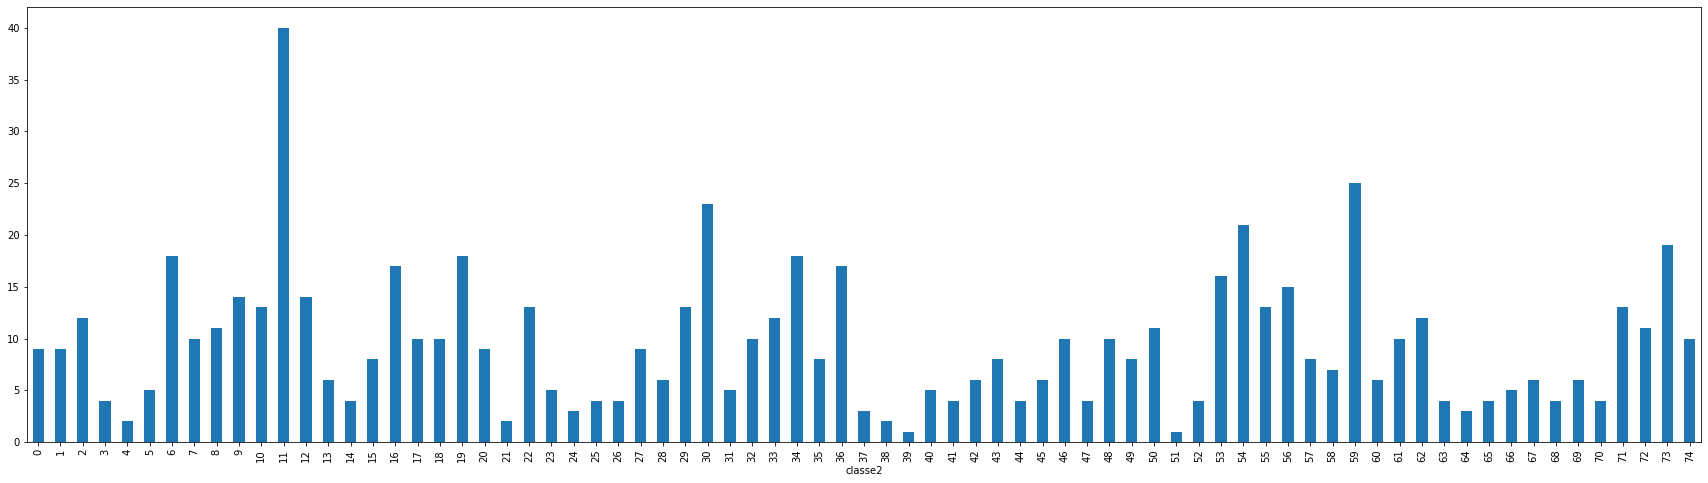

In [ ]:
'''df_teste['classe2'] = y_prob
fig = plt.figure(figsize=(30,8))
df_teste.groupby('classe2').classe.count().plot.bar(ylim=0)
#df_val[df_val['classe']!=1000].groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()'''
df_val['classe2'] = y_prob
fig = plt.figure(figsize=(30,8))
df_val[df_val['classe2']!=1000].groupby('classe2').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
#n = 104
testando = df_val[df_val['classe2']==n]
print(len(testando))
testando['xprod'].unique()

#### Super-learner

https://machinelearningmastery.com/super-learner-ensemble-in-python/

In [ ]:
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict_proba(X)
		meta_X.append(yhat)
	meta_X = hstack(meta_X)
 
	return meta_model.predict_proba(meta_X)

In [ ]:
#models = abre (path_modelos+"models_super_model.pkl")
#meta_model = abre(path_modelos+"meta_super_model.pkl")

y_prob = super_learner_predictions(X_test_tfidf, models, meta_model)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
accuracy_score(y_test.tolist(), y_prob)

0.8760330578512396

In [ ]:
df_teste['classe'] = y_prob
fig = plt.figure(figsize=(30,8))
df_teste.groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
n = 14
testando = df_teste[df_teste['classe']==n]
testando['Produto'].unique()

In [ ]:
#models = abre (path_modelos+"models_super_model.pkl")
#meta_model = abre(path_modelos+"meta_super_model.pkl")

y_prob = super_learner_predictions(X_val_tfidf_ruido, models, meta_model)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
df_val['classe'] = y_prob
accuracy_score(y_val_ruido, y_prob)

0.9675754515875687

In [ ]:
fig = plt.figure(figsize=(30,8))
df_val[df_val['classe']!=1000].groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
n = 57
testando2 = df_val[df_val['classe']==n]
testando2['Produto'].unique()

array(['resma de papel a4 - 500 folhas',
       'papel a4 210x297mm caixa com 10 resma de 500 fls',
       'papel a4 210x297 c/500f chamex',
       'papel tipo a4,gramatura de 75/m2, medindo 210x297mm, na cor branca. resma com 500 folhas.',
       'papel oficio a4 branco 75gm2 210x297 c/500f',
       'prontuário de internação a4 75g c/ 100fls',
       'papel a4 para clientes', 'pasta l tam a4 polibras',
       'papel oficio a4 210x297 br cx c/10 resmas chamex',
       'papel oficio copimax a4 c/10 rm',
       'papel oficio resma com 500 folhas cx c/10 resmas chamex',
       'papel formato a4 210x297mm 75g/,² reciclado',
       'papel chamex a4 office 210x297 ofc075ca4',
       'papel oficio 9 resma c/ 500 fls report',
       'papel peso 40 a4 bco 250 fls 120g/m 40kg',
       'pasta tipo sanfonada tam a4 com 12 divisoria em plastico',
       'papel a4 colegial 120 gr 40 kg branco ofsset c/50 fls',
       'papel branco 75 grs a-4 210x297 c/500 fls',
       'papel oficio report senninha 1

In [ ]:
testando2['xprod'].unique()

In [ ]:
#df_treino[df_treino['Produto'].str.contains('preto')].iloc[np.random.randint(len(df_treino[df_treino['Produto'].str.contains('preto')]),size=50)]
t = df_treino[df_treino['definicao']==n]
t.iloc[np.random.randint(len(t),size=50)]

#### Bagging out-of-fold

In [ ]:
bagg = abre(path_modelos+"bagg.pkl")
y_prob = bagg.predict_proba(X_val_tfidf_ruido)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
#accuracy_score(y_test.tolist(), y_prob)
accuracy_score(y_val_ruido, y_prob)

0.969079859260049

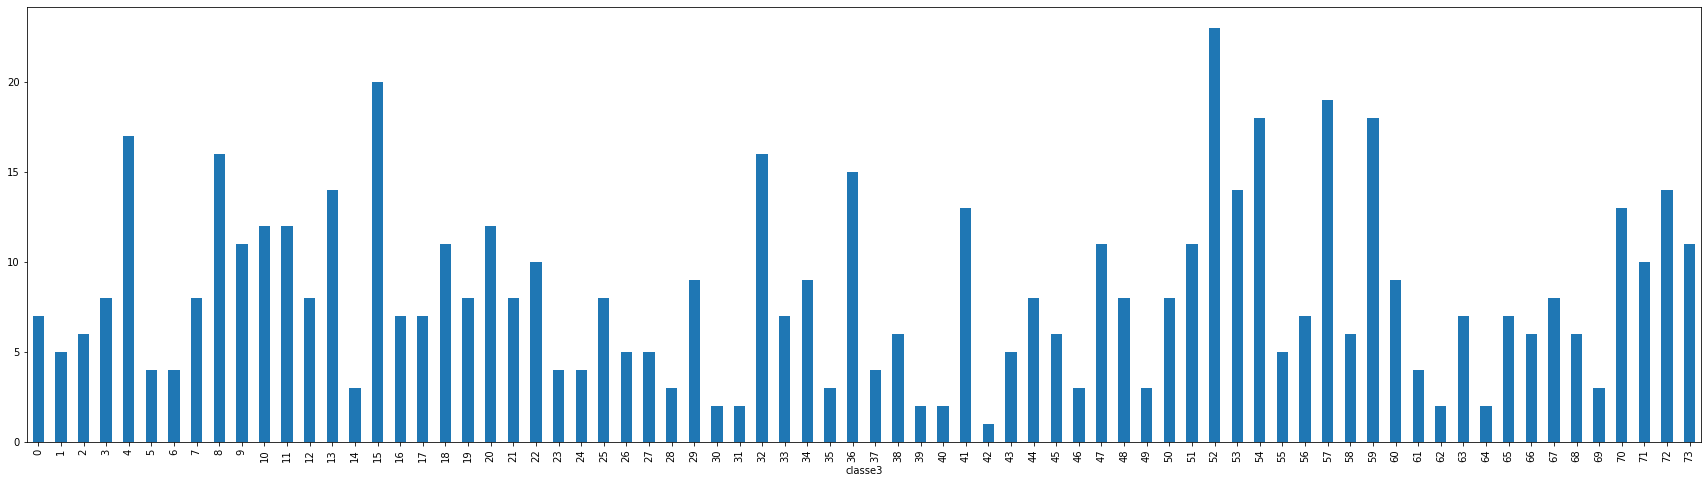

In [ ]:
df_val['classe3'] = y_prob
fig = plt.figure(figsize=(30,8))
df_val[df_val['classe3']!=1000].groupby('classe3').classe3.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
n = 0
testando3 = df_val[df_val['classe3']==n]
testando3['Produto'].unique()

array(['achocolatado em po da barra 700g',
       'achocolatado em po tipo instantaneo enriquecido com vitaminasembalado em sache flexivel em polietile',
       'achoc.po 400g marata', 'nescau achoc po 400g br',
       'achocolatado em po 400g chocomil',
       'achocolatado em po 400gr chocolato', 'achocolatado em po 400g'],
      dtype=object)

In [ ]:
t2 = df_treino[df_treino['definicao']==n]
t2.iloc[np.random.randint(len(t2),size=50)]

#### Votação Hard

In [ ]:
y_prob = clf.predict_proba(X_test_tfidf)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
accuracy_score(y_test.tolist(), y_prob)

0.8514851485148515

In [ ]:
y_prob = clf.predict_proba(X_val_tfidf)

df_val_sem_ruido['classe'] = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
#df_val_sem_ruido['classe'] = df_val_sem_ruido['classe'].apply(lambda x: int(x) if not pd.isna(x) else 1000)
df_val_sem_ruido['definicao'] = df_val_sem_ruido['definicao'].apply(lambda x: int(x))
print('Accuracia:{0:.2f}\n'.format(accuracy_score(df_val_sem_ruido['definicao'], df_val_sem_ruido['classe'])))

In [ ]:
plt.figure(figsize=(45,25))
cm = confusion_matrix(df_val_sem_ruido['definicao'], df_val_sem_ruido['classe'])
sns.heatmap(cm, annot=True, cbar=False, fmt='g', xticklabels = real_groups, yticklabels = real_groups)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Accuracy:{0:.2f}'.format(accuracy_score(df_val_sem_ruido['definicao'], df_val_sem_ruido['classe'])))

### outros

In [ ]:
#y_prob = clf.predict_proba(doc_vectors_std_umap_teste)
y_prob = clf.predict_proba(X_test_tfidf_others)
y_pred_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.90 else None for probs in y_prob ]
df_test['classe'] = y_pred_prob
qtd=df_test[~df_test['classe'].isna()]
print(f'Novas amostras detectadas: {len( qtd )}')

Novas amostras detectadas: 21673


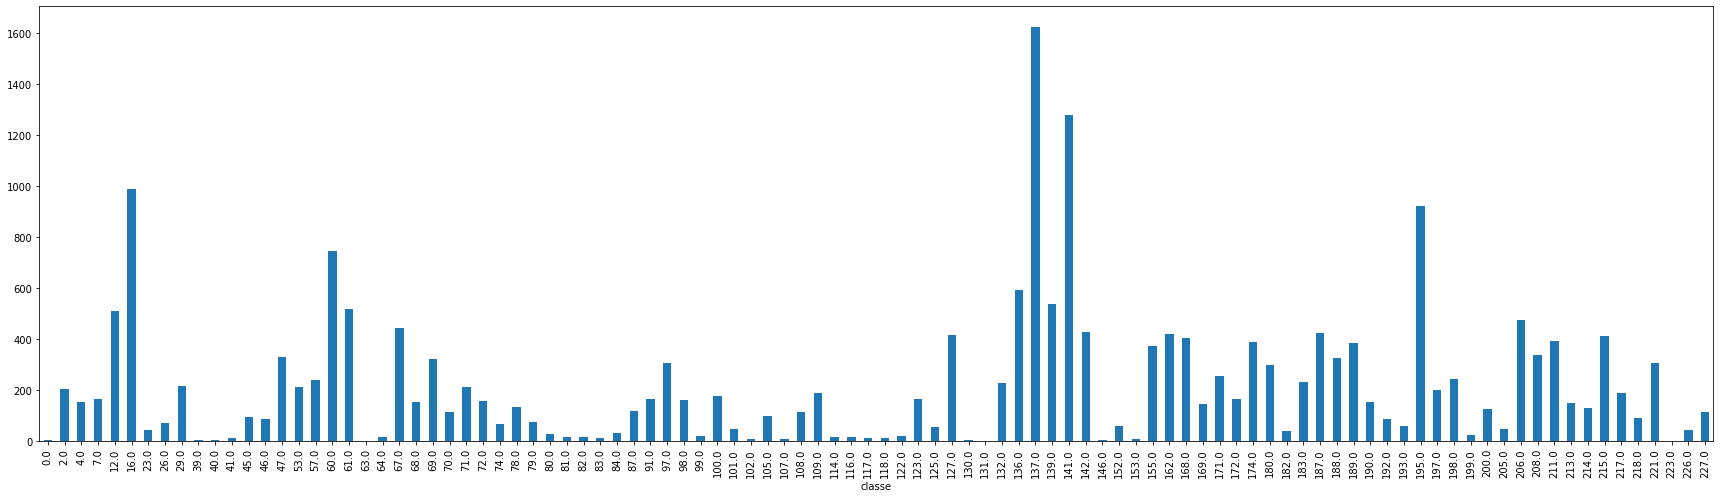

In [ ]:
fig = plt.figure(figsize=(30,8))
df_test.groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
n = 67
testando = df_test[df_test['classe']==n]
testando['Produto'].unique()

array(['bolacha cream cracker 400g', 'biscoito cream craker integral',
       'cream cracker 400g', 'biscoito salgado cream creacker 400g',
       'biscoito salgado cream cracker pct 400g',
       'biscoito cream cream craker', 'biscoito cream cream craker cx',
       'biscoito cream cracker integral 400g', 'cream cracker integral',
       'biscoito cream craker 400grs pct estrela',
       'biscoito sal c cracker estrela 400gr',
       'biscoito salgado integral 400g estrela', 'biscoito cream cracker',
       'biscoito salgado ceram cracker estrela',
       'biscoito cream craker estrela 400gr',
       'biscoito salgado 400g estrela',
       'biscoito salgado integral 400g vitabono',
       'biscoito cream craker 400g',
       'biscoito salgado cream craker integral 400g estrela',
       'biscoito cream cracker 400g marilan',
       'biscoito salgado integral 400g',
       'biscoito salgado cream craker 400grs pct estrela',
       'biscoito cream cracker integral 400g estrela',
       

In [ ]:
df_original[df_original['definicao']==n][:30][['Produto','xprod']] 

In [ ]:
#df_aux[~df_aux['classe'].isna()].iloc[np.random.randint(len(df_aux[~df_aux['classe'].isna()]),size=15)][['Produto','classe']]
#df[df['definicao']==53]['xprod'].unique().tolist()

In [ ]:
'''
n1 = 53
n2 = 5
#df_aux[df_aux['xprod'].str.contains('oleo deisel')][:50]
lista_teste= df[df['definicao']==n1]['xprod'].unique().tolist() + df[df['definicao']==n2]['xprod'].unique().tolist()
vocab = [word for descr in lista_teste for word in descr.split()]
dict1 = [word for descr in df[df['definicao']==n1]['xprod'].unique().tolist() for word in descr.split()]
dict2 = [word for descr in df[df['definicao']==n2]['xprod'].unique().tolist() for word in descr.split()]
resu= [word for word in set(vocab) if word in dict2 and word in dict1]
resu'''

### word2vec

In [ ]:
'''qtd_palavras = 10
qtd_dimensoes = 300
qtd_dimensoes_umap = 10
# map index do valor predito com a classe real 
pickle_off = open ("real_groups.pkl", "rb")
real_groups = pickle.load(pickle_off)
dictionary = dict(zip(list(range(len(real_groups))), real_groups))'''

In [ ]:
'''pickle_off = open ("produtos_test1.pkl", "rb")
df_aux = pickle.load(pickle_off)
sentences_teste = [descr.split()[:qtd_palavras] for descr in df_aux['xprod']]
doc_vectors_teste = {}
for number, sent in enumerate(sentences_teste):
    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:
    if len(sent) == 0:
        doc_vectors_teste[number] = np.zeros(qtd_dimensoes,)
    elif len(sent) == 1:
        doc_vectors_teste[number] = ft.get_word_vector(sent[0])
    elif len(sent) > 1:
        pesos = np.array(range(len(sent))[::]) + 1
        pesos = 1 / pesos
        media = []
        divisao = 0
        counter = 0
        for word in sent:
            if word.isdigit():
                media.append(ft.get_word_vector(word) * ((pesos[0]+pesos[-1])*(1/2)) )
                divisao += ((pesos[0]+pesos[-1])*(1/2))
            else:
                media.append(ft.get_word_vector(word) * pesos[counter])
                divisao += pesos[counter]
            counter += 1
        doc_vectors_teste[number] = np.array(media).sum(axis=0) / divisao #media de tudo'''

In [ ]:
'''doc_vectors_teste = pd.DataFrame(doc_vectors_teste).T
doc_vectors_teste = doc_vectors_teste.set_index(df_aux.index) 

scaler = StandardScaler()
doc_vectors_std_df_teste = pd.DataFrame(scaler.fit_transform(doc_vectors_teste),index=doc_vectors_teste.index,columns=doc_vectors_teste.columns)'''

In [ ]:
'''umap_redux = umap.UMAP(n_components=qtd_dimensoes_umap, random_state=999, metric='cosine',verbose=True)
umap_redux.fit(doc_vectors_std_df_teste)
doc_vectors_std_df_umap_teste = umap_redux.transform(X=doc_vectors_std_df_teste)'''

In [ ]:
#pickle_off = open ("modelo.pkl", "rb")
#clf = pickle.load(pickle_off)

## Salva Resu

### absorve outros

In [ ]:
df_original['classe'] = df_original['definicao']
#df_aux = df_aux[~df_aux['classe'].isna()]
df_final = pd.concat([df_original, df_aux])

In [ ]:
fig = plt.figure(figsize=(20,5))
df_final.groupby('classe').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

### outros save

#### save

In [ ]:
'''df = df_produto[~df_produto['definicao'].isin(['outros'])] 

le = LabelEncoder()
df['classe'] = le.transform(df.definicao)
descricoes = le.classes_
grupos = le.transform(le.classes_)
'''

In [ ]:
calc_preco(df_final, grupos, descricoes)
df_final = df_final.round(2)
df_final['qcom'] = df_final['qcom'].astype(int)
df_final['vuncom'] = df_final['vuncom'].astype(str).str.replace('.',",")  
df_final['vprod'] = df_final['vprod'].astype(str).str.replace('.',",")
df_final = reindex_grupos(df_final)
df_final.to_csv('produtos_classificados.csv', encoding="utf-8-sig")

In [ ]:
'''
#mesclando classes preditas com determinadas
df_teste = pd.DataFrame(y_test)
df_train = pd.DataFrame(y_train)
#y_pred n preserva index, tem q pegar do teste (sobrescreve teste)
df_teste['definicao'] = y_pred.tolist()

df['classe'] = pd.concat([df_teste, df_train])

#df_out['classe'] = df_out['definicao']
#df = pd.concat([df, df_out])
'''